Importing the modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import itertools
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pickle
import cv2
import random as rn
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import densenet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from numpy.random import seed

In [4]:
!pip install scikit-image

In [5]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K

In [6]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((128,128))
image_size = 0
directory_root =r'C:\Users\TSA\plantdis'
#directory_root = r'/content/drive/MyDrive/SKIN'

width=56
height=56
depth=3

Uploading and converting the images

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/plant_folder")


        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")

            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            print(plant_disease_folder)
            i=len(plant_disease_image_list)
            print (i)
            for image in plant_disease_image_list[:10000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                elif image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                elif image_directory.endswith(".jfif") == True or image_directory.endswith(".JFIF") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Type_1 ...
Type_1
1286
[INFO] Processing Type_2 ...
Type_2
831
[INFO] Processing Type_3 ...
Type_3
1976
[INFO] Image loading completed


In [9]:
image_size = len(image_list)
print(image_size)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_densenet.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float32) / 225.0

print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels,
                                                    test_size=0.2, random_state = 42,shuffle=True)

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    zoom_range=0.2,
    vertical_flip=True
    )

4093
[INFO] Spliting data to train, test


In [10]:
input_shape=224,244,3

Training the models

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate

# Load pre-trained VGG16 and DenseNet121 models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
dense_model = DenseNet121(include_top=False, weights="imagenet", input_shape=(128, 128, 3))

In [12]:
# Freeze layers in both models
for layer in dense_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_output = vgg_model.output
dense_output = dense_model.output

In [13]:
In = Input([128,128,3])

In [14]:
model_concat = Concatenate()([vgg_output, dense_output])

# Flatten and add dense layers
model_combined = Flatten()(model_concat)
model_combined = Dense(1024, activation='relu')(model_combined)
model_combined = Dense(512, activation='relu')(model_combined)
model_combined = Dense(256, activation='relu')(model_combined)
model_combined = Dense(3, activation='softmax')(model_combined)

In [15]:
final_model = Model(inputs=[vgg_model.input,dense_model.input], outputs=model_combined)

In [16]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']      

In [18]:
vgg_input = vgg_model.input
densenet_input = dense_model.input

In [19]:
from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_test are integer labels
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [20]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
hist = final_model.fit([x_train,x_train],y_train,validation_data=([x_test,x_test],y_test),batch_size=64,
          epochs=50,verbose=1,shuffle=True)

Epoch 1/50


52/52 [==============================] - 196s 3s/step - loss: 3.8040 - accuracy: 0.5321 - val_loss: 0.9675 - val_accuracy: 0.6484
Epoch 2/50
52/52 [==============================] - 166s 3s/step - loss: 0.6778 - accuracy: 0.7214 - val_loss: 0.7248 - val_accuracy: 0.6813
Epoch 3/50
52/52 [==============================] - 165s 3s/step - loss: 0.6198 - accuracy: 0.7389 - val_loss: 0.6379 - val_accuracy: 0.7265
Epoch 4/50
52/52 [==============================] - 174s 3s/step - loss: 0.4830 - accuracy: 0.7938 - val_loss: 0.6960 - val_accuracy: 0.7350
Epoch 5/50
52/52 [==============================] - 170s 3s/step - loss: 0.4159 - accuracy: 0.8241 - val_loss: 0.7950 - val_accuracy: 0.6703
Epoch 6/50
52/52 [==============================] - 184s 4s/step - loss: 0.3481 - accuracy: 0.8705 - val_loss: 0.5681 - val_accuracy: 0.7778
Epoch 7/50
52/52 [==============================] - 188s 4s/step - loss: 0.2332 - accuracy: 0.9117 - val_loss: 0.7462 - val_accuracy: 0.7473
Epoch 8/50


In [22]:
hist

Plot performance

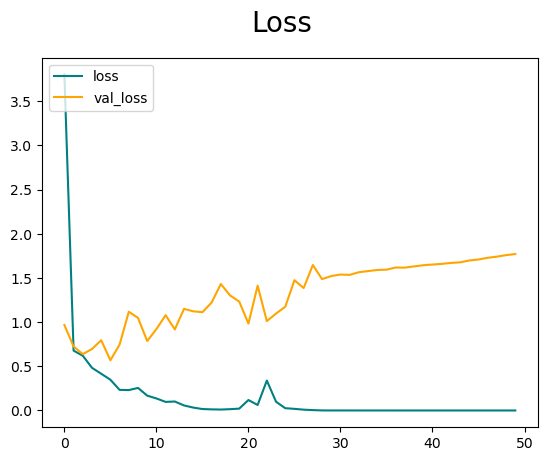

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

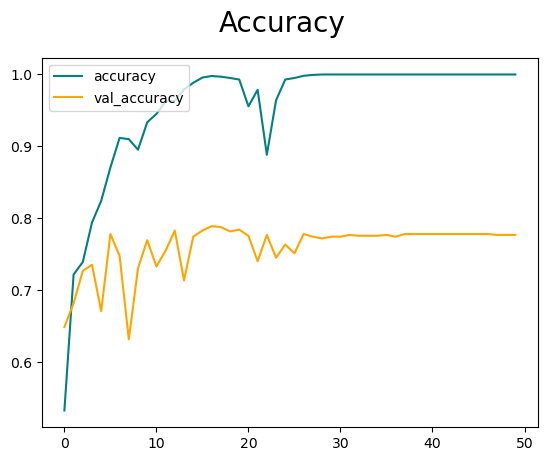

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()